In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Union

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

C:\Users\denok\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
plt.style.use("ggplot")

# View Data

In [3]:
@dataclass
class Features:
    sample_rate: int = 22050
    hop_length: int = 220
    n_fft: int = 2048
    n_frames_per_example: int = 1


def load_wav(path: Union[str, Path], sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(file_path: Union[str, Path], params: Features) -> List[np.ndarray]:
    waveform = load_wav(file_path, sample_rate=params.sample_rate)

    spectrogram = librosa.feature.melspectrogram(
        waveform, n_fft=params.n_fft, hop_length=params.hop_length
    )

    spectrogram = np.log(1e-20 + np.abs(spectrogram**2))

    n_examples = spectrogram.shape[1] // params.n_frames_per_example

    return [
        spectrogram[
            :, i * params.n_frames_per_example : (i + 1) * params.n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

C:\Users\denok\AppData\Local\Temp\ipykernel_23468\3350153032.py:17: FutureWarning: Pass y=[-0.16705322 -0.16708374 -0.15670776 ...  0.1411438   0.17166138
  0.19277954] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(


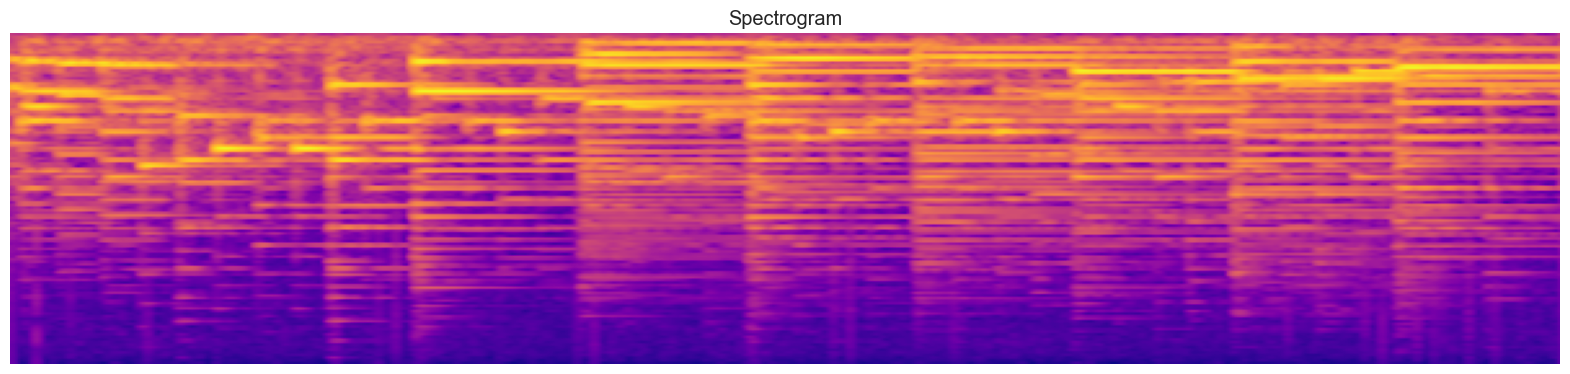

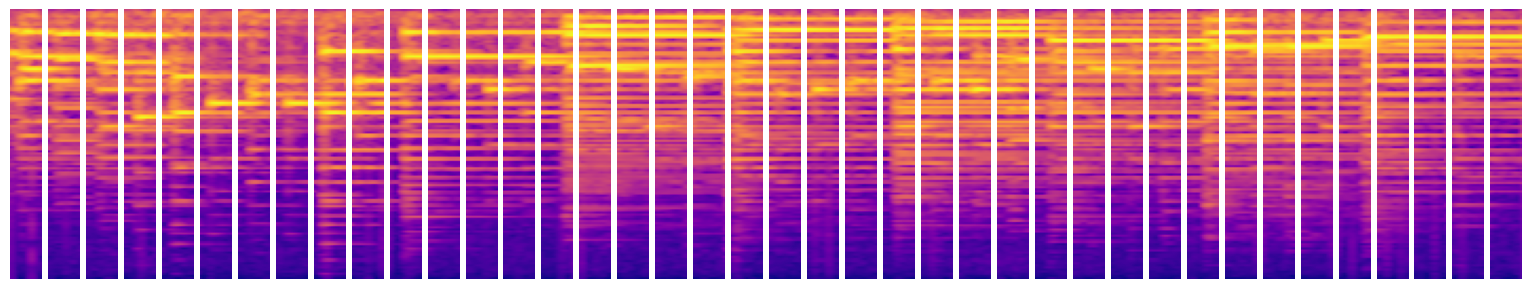

In [4]:
# 1161154212832220511.wav
# 1429195257218202828.wav

PATH = "./train/classical/1429195257218202828.wav"
PARAMS = Features(n_frames_per_example=15)

ipd.display(ipd.Audio(PATH))

sample_features = [
    feature.reshape(-1, PARAMS.n_frames_per_example)
    for feature in extract_features(file_path=PATH, params=PARAMS)
]

plt.figure(figsize=(20, 5))
plt.title("Spectrogram")
plt.imshow(np.hstack(sample_features), cmap="plasma")
plt.axis("off")
plt.savefig("spectrogram.png", dpi=200)
plt.show()

plt.figure(figsize=(20, 5))
for i, feature in enumerate(sample_features):
    plt.subplot(1, len(sample_features) + 1, i + 1)
    plt.imshow(feature, cmap="plasma")
    plt.axis("off")
plt.show()

# Prepare Train Dataset

In [5]:
def load_folder_data(
    path: Path, train: bool, params: Features
) -> Tuple[List[List[np.ndarray]], List[List[str]], List[Path]]:
    features: List[List[np.ndarray]] = []
    labels: List[List[str]] = []
    file_names: List[Path] = list(path.rglob("*.wav"))

    for file_path in file_names:
        file_features = extract_features(file_path, params)

        features.append(file_features)

        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))

    return features, labels, file_names

In [6]:
@dataclass
class ExpConfig:
    features: Features = Features(
        sample_rate=22050,
        hop_length=220,
        n_fft=2048,
        n_frames_per_example=1,
    )
    random_state: int = 42
    test_size: float = 0.1
    train_path: Path = Path("./train")
    test_path: Path = Path("./test")


config = ExpConfig()

In [7]:
class_names = [folder.name for folder in config.train_path.iterdir()]

class_name2id: Dict[str, int] = {
    class_name: class_id for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(
    path=config.train_path, train=True, params=config.features
)

labels_int: List[List[int]] = [
    [class_name2id[label] for label in label_list] for label_list in labels
]

C:\Users\denok\AppData\Local\Temp\ipykernel_23468\3350153032.py:17: FutureWarning: Pass y=[-0.17230225 -0.12597656 -0.10513306 ...  0.1685791   0.18972778
  0.2098999 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(
C:\Users\denok\AppData\Local\Temp\ipykernel_23468\3350153032.py:17: FutureWarning: Pass y=[-0.03164673 -0.01638794 -0.01071167 ...  0.2083435   0.29504395
  0.26254272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(
C:\Users\denok\AppData\Local\Temp\ipykernel_23468\3350153032.py:17: FutureWarning: Pass y=[-0.07815552 -0.10876465 -0.14413452 ...  0.07739258  0.07342529
  0.06045532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(
C:\Users\denok\AppData\Local\Temp\ipykernel_23468\33501530

In [8]:
(
    features_train,
    features_test,
    labels_train,
    labels_test,
    files_train,
    files_test,
) = train_test_split(
    features,
    labels_int,
    file_names,
    random_state=config.random_state,
    test_size=config.test_size,
)

In [9]:
X_train = np.vstack([x for list_ in features_train for x in list_])
y_train = np.array([x for list_ in labels_train for x in list_])

In [10]:
X_train.shape

(2438084, 128)

In [11]:
# !pip install xgboost==0.90
# !pip install catboost

In [12]:
from catboost import CatBoostClassifier

In [25]:
cbc = CatBoostClassifier(task_type="GPU",classes_count=10,n_estimators=500, random_state=42, loss_function='MultiClass',learning_rate=0.7, reg_lambda=100)

In [26]:
pipe = Pipeline([("scaler", StandardScaler()), ("clf", cbc)]).fit(
    X_train, y_train
)

0:	learn: 1.9139008	total: 330ms	remaining: 2m 44s
1:	learn: 1.7649900	total: 569ms	remaining: 2m 21s
2:	learn: 1.7050036	total: 790ms	remaining: 2m 10s
3:	learn: 1.6621368	total: 1.01s	remaining: 2m 4s
4:	learn: 1.6250837	total: 1.19s	remaining: 1m 57s
5:	learn: 1.5938135	total: 1.4s	remaining: 1m 55s
6:	learn: 1.5654704	total: 1.63s	remaining: 1m 54s
7:	learn: 1.5419614	total: 1.84s	remaining: 1m 53s
8:	learn: 1.5186917	total: 2.07s	remaining: 1m 52s
9:	learn: 1.4977465	total: 2.27s	remaining: 1m 51s
10:	learn: 1.4795555	total: 2.47s	remaining: 1m 50s
11:	learn: 1.4606654	total: 2.71s	remaining: 1m 50s
12:	learn: 1.4481233	total: 2.91s	remaining: 1m 49s
13:	learn: 1.4327423	total: 3.13s	remaining: 1m 48s
14:	learn: 1.4219462	total: 3.32s	remaining: 1m 47s
15:	learn: 1.4084863	total: 3.54s	remaining: 1m 47s
16:	learn: 1.3962856	total: 3.72s	remaining: 1m 45s
17:	learn: 1.3825873	total: 3.91s	remaining: 1m 44s
18:	learn: 1.3723886	total: 4.1s	remaining: 1m 43s
19:	learn: 1.3599288	tota

# Interpretation

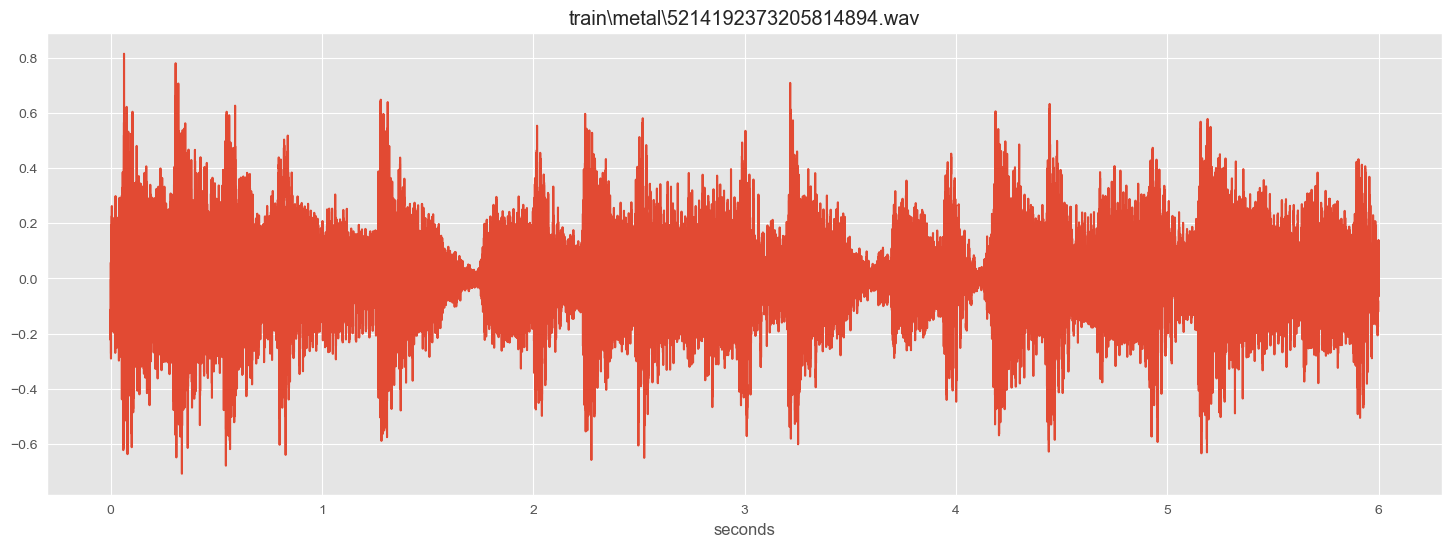

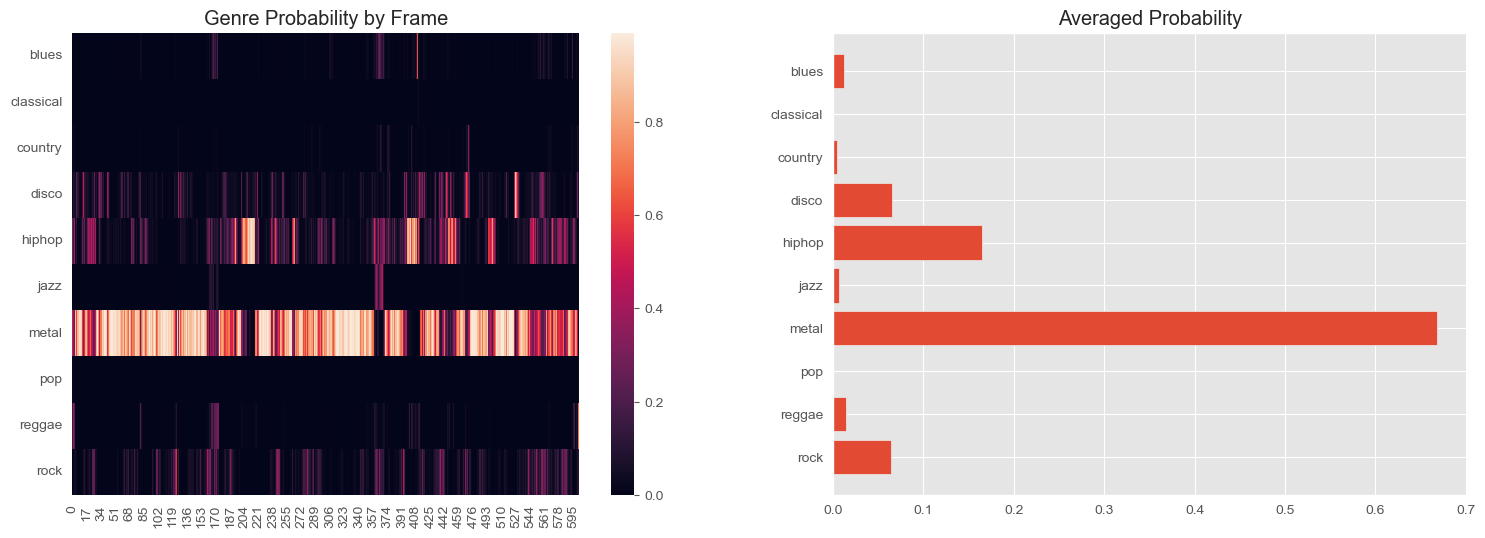

In [27]:
TEST_ID = 892

predictions = pipe.predict_proba(np.vstack(features_train[TEST_ID]))

plt.figure(figsize=(18, 6))
plt.title(files_train[TEST_ID])
wave_form = load_wav(files_train[TEST_ID], sample_rate=config.features.sample_rate)
time_axis = [x / config.features.sample_rate for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel("seconds")
plt.show()

ipd.display(ipd.Audio(files_train[TEST_ID]))
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title("Genre Probability by Frame")
sns.heatmap(predictions.T, yticklabels=class_names)

plt.subplot(122)
plt.title("Averaged Probability")
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

## Confusion matrix

In [28]:
def plot_conf_matrix(
    y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool = False
) -> None:
    plt.figure(figsize=(8, 6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        annot=annot,
    )
    plt.show()

### by record

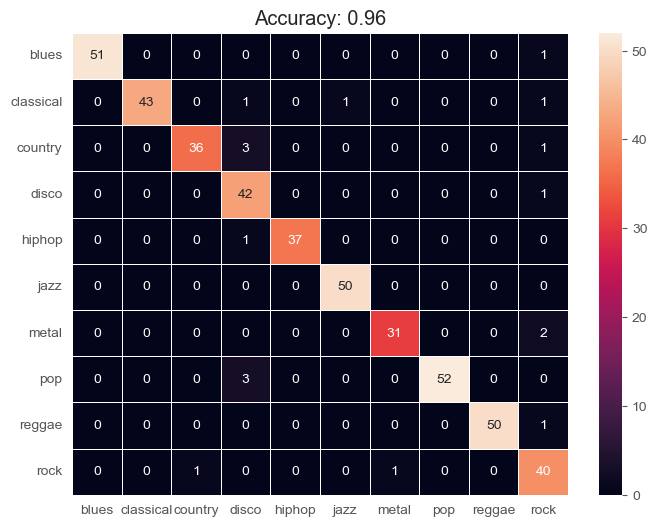

In [29]:
y_pred = np.array(
    [
        pipe.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])


plot_conf_matrix(y_pred, y_test, class_names, annot=True)

# Test

In [30]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)

C:\Users\denok\AppData\Local\Temp\ipykernel_23468\3350153032.py:17: FutureWarning: Pass y=[ 0.03451538  0.03128052  0.02001953 ... -0.0479126  -0.05615234
 -0.03405762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(
C:\Users\denok\AppData\Local\Temp\ipykernel_23468\3350153032.py:17: FutureWarning: Pass y=[ 0.03137207  0.06652832  0.09204102 ...  0.04327393 -0.0736084
 -0.16888428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(
C:\Users\denok\AppData\Local\Temp\ipykernel_23468\3350153032.py:17: FutureWarning: Pass y=[-0.33743286 -0.31896973 -0.3239746  ... -0.00170898 -0.01071167
  0.01034546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(
C:\Users\denok\AppData\Local\Temp\ipykernel_23468\335015303

In [31]:
predictions = [
    class_names[pipe.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
    for test_feature in test_features
]

In [32]:
len(predictions)

500

In [33]:
ind=[test_wav_path.name for test_wav_path in config.test_path.iterdir()][:500]

In [34]:
len(ind)

500

In [35]:
(
    pd.DataFrame(
        {
            "index": ind,
            "genre": predictions,
        }
    ).to_csv("submit.csv", index=False)
)

In [36]:
len(labels_test)

450